<a href="https://colab.research.google.com/github/dee110770/Capstone-Project--Group-10/blob/main/SARIMA_model_and_Exponential_smoothing_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [1]:
#import libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score




In [2]:
#load the dataset
df = pd.read_csv('weekly_avg_admissions_from_daily (1).csv')
df.head()

,collection_date,average_admissions_all_covid_confirmed
0,2020-08-02,101.007003
1,2020-08-09,93.713085
2,2020-08-16,84.008003
3,2020-08-23,83.309724
4,2020-08-30,77.724690


Train data shape: (156, 2)
Validation data shape: (40, 2)


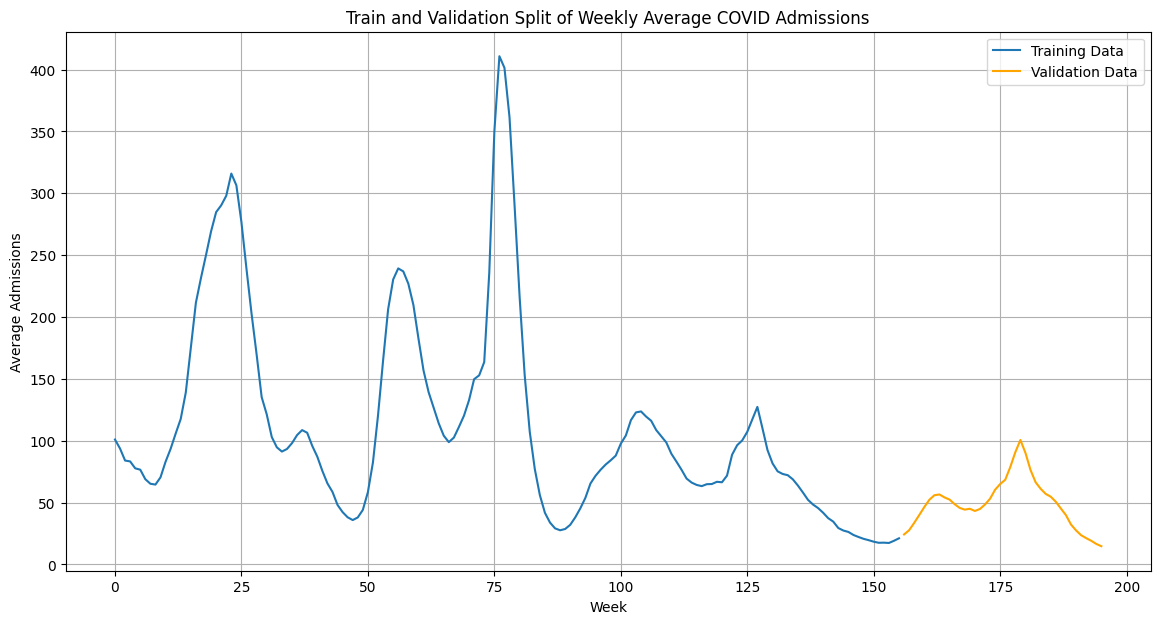


Data split into training and validation sets.
Train set covers from 0 to 155
Validation set covers from 156 to 195


In [3]:
# Define the proportion of data to use for training (e.g., 80%)
train_size = int(len(df) * 0.8)

# Split the data
train_data = df[:train_size]
validation_data = df[train_size:]

print("Train data shape:", train_data.shape)
print("Validation data shape:", validation_data.shape)

# Plot the split
plt.figure(figsize=(14, 7))

try:
    # plotting using the average admissions column
    plt.plot(train_data.index, train_data['average_admissions_all_covid_confirmed'], label='Training Data')
    plt.plot(validation_data.index, validation_data['average_admissions_all_covid_confirmed'], label='Validation Data', color='orange')
except KeyError:
    print("Column 'average_admissions' not found. Trying to plot the second column (index 1).")
    if df.shape[1] > 1:
        plt.plot(train_data.index, train_data.iloc[:, 1], label='Training Data')
        plt.plot(validation_data.index, validation_data.iloc[:, 1], label='Validation Data', color='orange')
    else:
        print("DataFrame does not have a second column to plot.")
        # Handle this case or raise an error if necessary


plt.title('Train and Validation Split of Weekly Average COVID Admissions')
plt.xlabel('Week')
plt.ylabel('Average Admissions')
plt.legend()
plt.grid(True)
plt.show()

print("\nData split into training and validation sets.")
print("Train set covers from", train_data.index.min(), "to", train_data.index.max())
print("Validation set covers from", validation_data.index.min(), "to", validation_data.index.max())


Train data shape: (156, 2)
Validation data shape: (40, 2)

Attempting to fit SARIMA model with order=(2, 0, 0) and seasonal_order=(1, 0, 1, 52)

SARIMA model fitted successfully.
                                         SARIMAX Results                                          
Dep. Variable:     average_admissions_all_covid_confirmed   No. Observations:                  156
Model:                   SARIMAX(2, 0, 0)x(1, 0, [1], 52)   Log Likelihood                -374.516
Date:                                    Sat, 31 May 2025   AIC                            759.031
Time:                                            17:00:01   BIC                            772.156
Sample:                                                 0   HQIC                           764.346
                                                    - 156                                         
Covariance Type:                                      opg                                         
                 coef    std

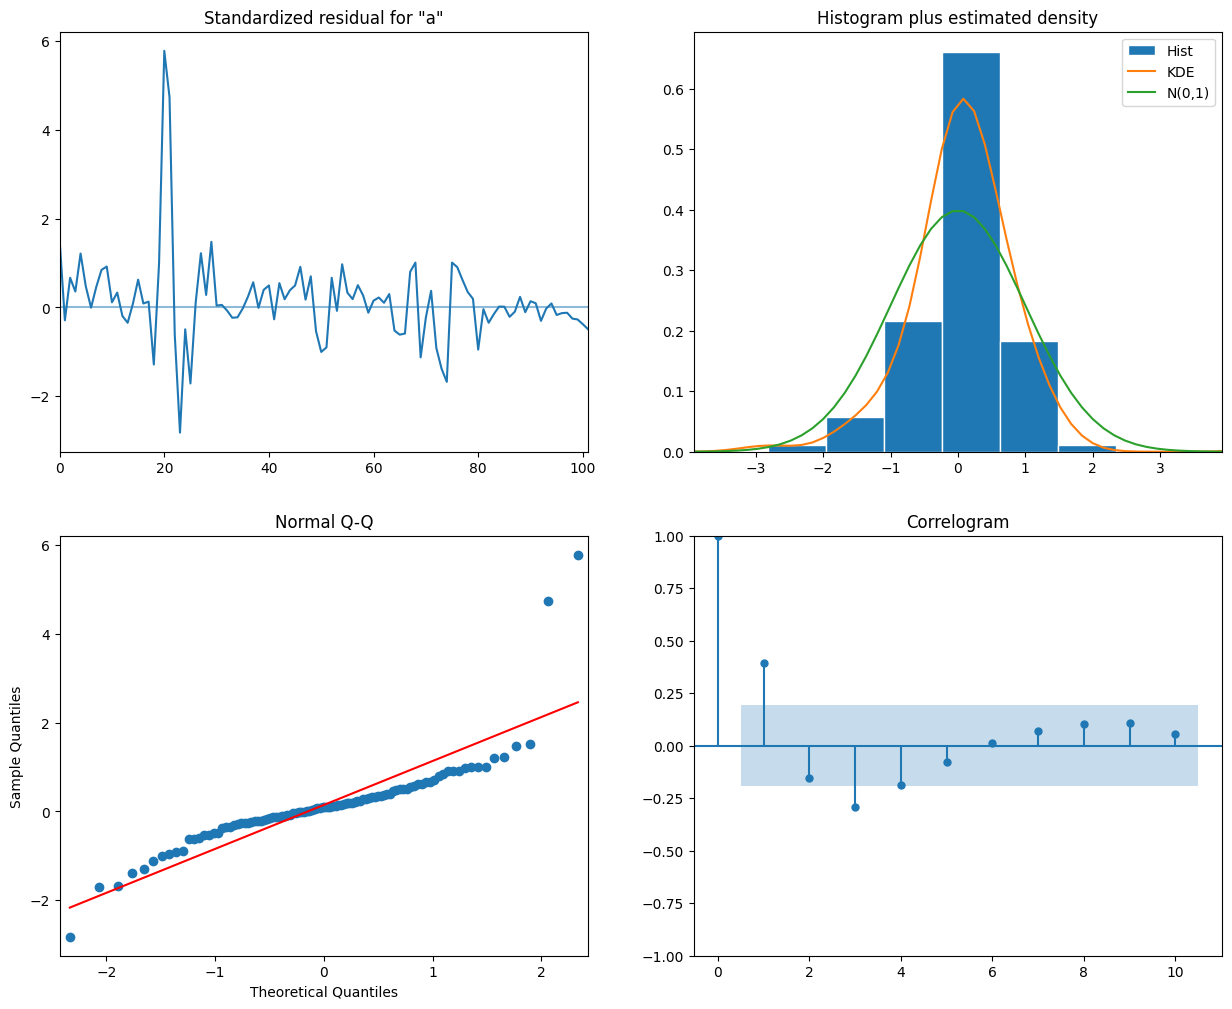


Evaluating model on validation set...


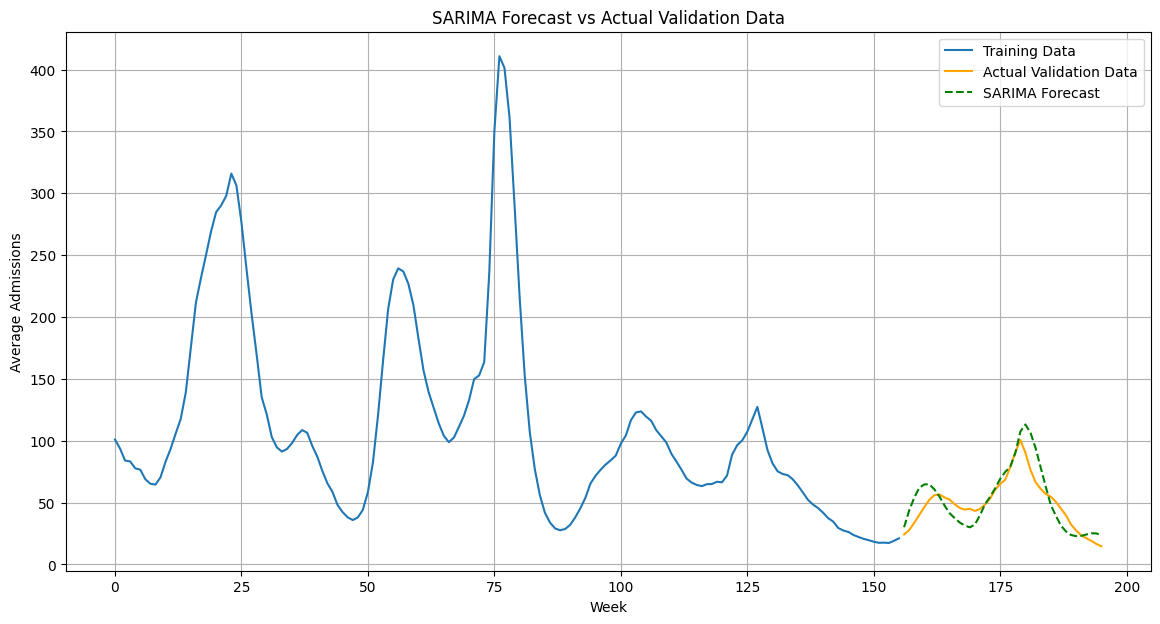

In [4]:
#shape of our train set and validation set
print("\nTrain data shape:", train_data.shape)
print("Validation data shape:", validation_data.shape)




# Select the target variable from the train and validation dataframes
train_ts = train_data['average_admissions_all_covid_confirmed']
validation_ts = validation_data['average_admissions_all_covid_confirmed']

# Define the SARIMA model parameters
order = (2, 0, 0)
seasonal_order = (1, 0, 1, 52)

print(f"\nAttempting to fit SARIMA model with order={order} and seasonal_order={seasonal_order}")

# Fit the SARIMA model on the training data
sarima_model = SARIMAX(train_ts.dropna(),
                       order=order,
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)

results = sarima_model.fit(disp=False, maxiter=1000)
print("\nSARIMA model fitted successfully.")

# Print the model summary
print(results.summary())

# Plot diagnostics to check residuals
print("\nPlotting model diagnostics...")
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Evaluate on the validation set
print("\nEvaluating model on validation set...")

# Get forecast for the length of the validation data
forecast_validation = results.get_forecast(steps=len(validation_ts))
forecast_mean_validation = forecast_validation.predicted_mean

# Calculate evaluation metric (Mean Absolute Error)
aligned_validation_ts, aligned_forecast_mean_validation = validation_ts.align(forecast_mean_validation, join='inner')

# Plot the forecast vs actual validation data
plt.figure(figsize=(14, 7))
plt.plot(train_ts.index, train_ts, label='Training Data')
plt.plot(validation_ts.index, validation_ts, label='Actual Validation Data', color='orange')
plt.plot(forecast_mean_validation.index, forecast_mean_validation, label='SARIMA Forecast', color='green', linestyle='--')
plt.title('SARIMA Forecast vs Actual Validation Data')
plt.xlabel('Week')
plt.ylabel('Average Admissions')
plt.legend()
plt.grid(True)
plt.show()

This model has the best overall fit, with much lower AIC, BIC, and residual variance. This strongly suggests that annual seasonality (52-week cycle) is the most appropriate for your data.

* All parameters are highly statistically significant.

* Residuals do not follow a normal distribution and are heteroskedastic.However, residual variance is significantly reduced, indicating better model capture of the signal.





1. Standardized Residual Plot for "a"

This plot shows how the standardized residuals vary across observations. Ideally, residuals should fluctuate randomly around zero.

However, there are noticeable spikes around index 20, which may indicate outliers or instances where the model struggled to fit the data well. If residuals show a systematic pattern, it suggests issues like heteroscedasticity or autocorrelation.

2. Histogram with Estimated Density

This plot helps visualize the distribution of residuals. The histogram shows most residuals clustering near zero, with fewer extreme values.

The orange kernel density estimate (KDE) follows the histogram shape closely, providing a smooth approximation of the residual distribution. The green curve represents a normal distribution (N(0,1)), which serves as a benchmark.

If residuals deviate significantly from the normal curve, it implies the model's assumptions of normality may not hold, potentially affecting inference.

3. Normal Q-Q Plot

This quantile-quantile plot compares the residuals' distribution to a theoretical normal distribution. Ideally, points should lie on the red diagonal line.

Most points align with this line, suggesting residuals are roughly normal. However, deviations at the extremes indicate heavier tails—this means the residuals may be slightly skewed or have more extreme values than expected under normality.

4. Correlogram (Autocorrelation Plot)

This plot assesses whether residuals from one observation are correlated with previous observations. Ideally, residuals should be uncorrelated.

Most autocorrelation bars remain within the confidence intervals (shaded region), suggesting no strong autocorrelation. However, a few lags appear slightly outside the interval, indicating mild correlation at certain points, which might need further investigation.

Overall Analysis
* The residuals exhibit reasonable normality but show some deviations in tail behavior.

* There is no strong autocorrelation, but occasional spikes in residuals could indicate model misfit or outliers.

* If the residuals were systematically structured rather than randomly distributed, it would suggest that important patterns in the data are not captured, meaning the model might need improvement.

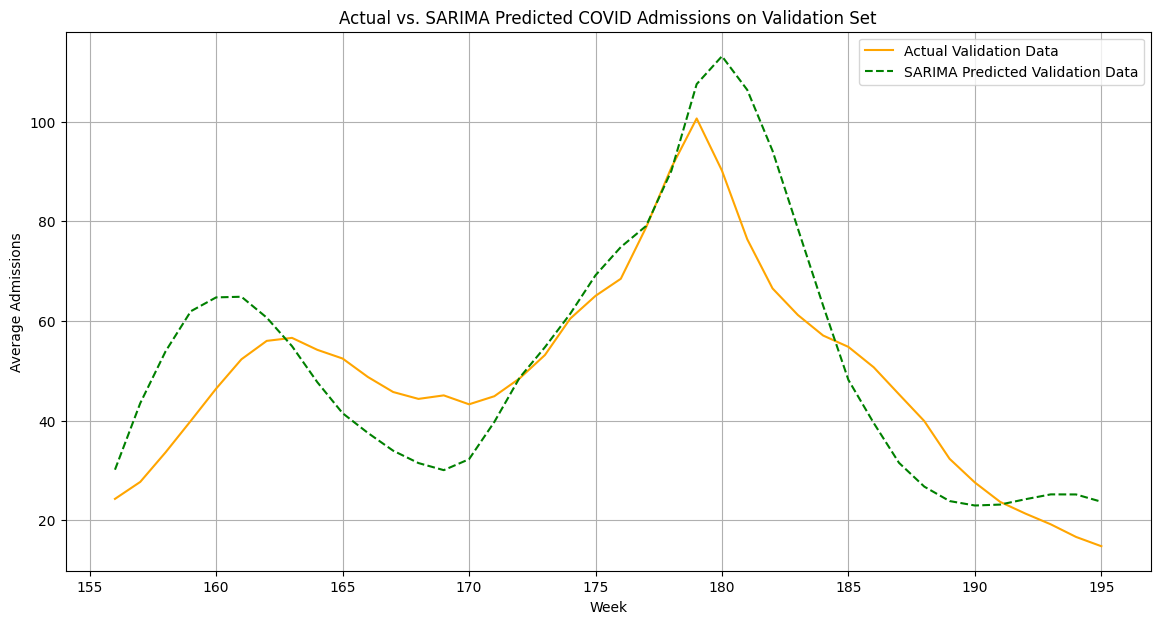

In [5]:
# Plot the actual vs predicted values for the validation set
plt.figure(figsize=(14, 7))

# Plot actual validation data
plt.plot(validation_ts.index, validation_ts, label='Actual Validation Data', color='orange')

# Plot predicted validation data
plt.plot(forecast_mean_validation.index, forecast_mean_validation, label='SARIMA Predicted Validation Data', color='green', linestyle='--')

plt.title('Actual vs. SARIMA Predicted COVID Admissions on Validation Set')
plt.xlabel('Week')
plt.ylabel('Average Admissions')
plt.legend()
plt.grid(True)
plt.show()




## Evaluation

In [6]:
# calculate the metrics of mae,rmse, mape and r2

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


# Calculate evaluation metrics
mae = mean_absolute_error(aligned_validation_ts, aligned_forecast_mean_validation)
rmse = np.sqrt(mean_squared_error(aligned_validation_ts, aligned_forecast_mean_validation))

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((aligned_validation_ts - aligned_forecast_mean_validation) / aligned_validation_ts)) * 100
# Replace inf with nan and drop nans if any true values were zero
mape = np.nan_to_num(mape, nan=np.inf, posinf=np.inf, neginf=np.inf)

# Calculate R-squared
r2 = r2_score(aligned_validation_ts, aligned_forecast_mean_validation)

print(f"\n--- Evaluation Metrics on Validation Set ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R2): {r2:.2f}")



--- Evaluation Metrics on Validation Set ---
Mean Absolute Error (MAE): 9.89
Root Mean Squared Error (RMSE): 12.37
Mean Absolute Percentage Error (MAPE): 23.14%
R-squared (R2): 0.62


Key Observations

Trend Matching
* The SARIMA model captures the general trend well, particularly:

* The steady rise in admissions around Week 170 to Week 179.

* The sharp peak around Week 179, where actual admissions reach ~100.

* The rapid decline following the peak, indicating that the model recognizes seasonal or trend-based drops.

Weaknesses:

* Early overprediction might indicate overfitting to seasonal lags or previous peak patterns.

* Post-peak underprediction of the fall suggests that the model may lag behind sudden shifts.

* Slight lags and mismatched amplitudes in transitional phases.

Summary Table

Metric	Value	Interpretation
* MAE	9.89	Model is off by ~10 admissions/week on average

* MSE	153.07	Some larger errors exist, but not extreme

* RMSE	12.37	Typical prediction error size
* R² Score	0.62	Explains 62% of the variation in data
* MAPE 23.14%- the model's predictions are off by an average of 23.14%

Good model performance overall, especially for time series forecasting:

MAE and RMSE are both within reasonable limits.

R² of 0.62 is decent for weekly real-world healthcare data (which can be noisy).

## Exponential smoothing Model


Attempting to fit Exponential Smoothing model...

Exponential Smoothing model fitted successfully.
                                ExponentialSmoothing Model Results                                
Dep. Variable:     average_admissions_all_covid_confirmed   No. Observations:                  156
Model:                               ExponentialSmoothing   SSE                           9974.974
Optimized:                                           True   AIC                            762.645
Trend:                                           Additive   BIC                            936.486
Seasonal:                                        Additive   AICC                           836.395
Seasonal Periods:                                      52   Date:                 Sat, 31 May 2025
Box-Cox:                                            False   Time:                         17:00:03
Box-Cox Coeff.:                                      None                                         
         

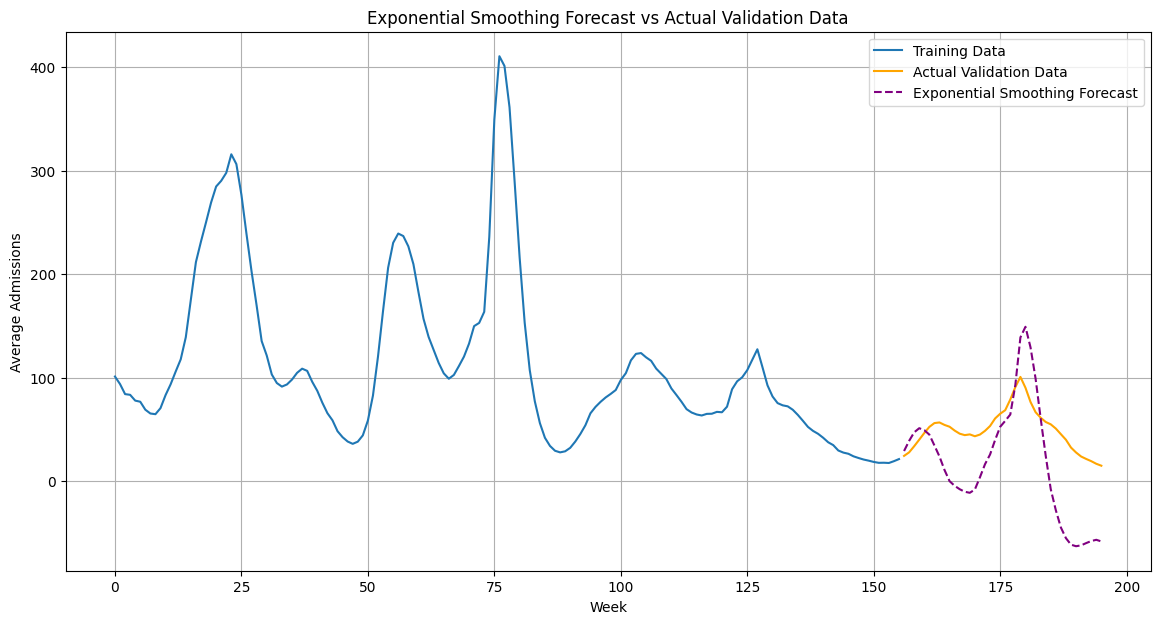

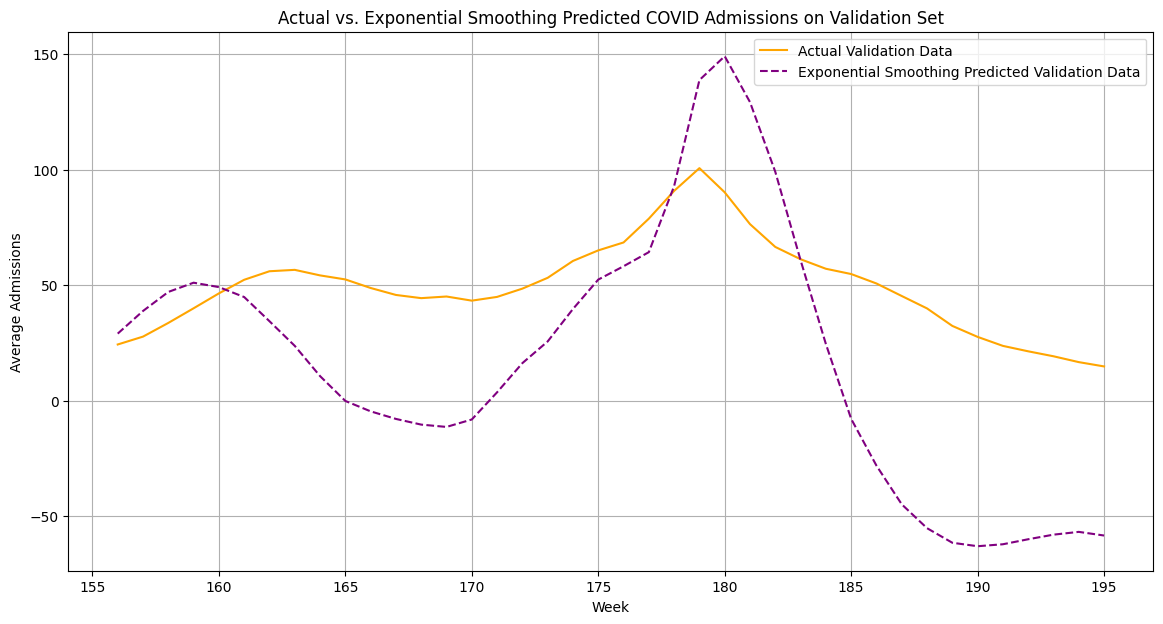

In [7]:
# Select the target variable from the train and validation dataframes
train_ts_es = train_data['average_admissions_all_covid_confirmed']
validation_ts_es = validation_data['average_admissions_all_covid_confirmed']

# Define the Exponential Smoothing model
es_model = ExponentialSmoothing(train_ts_es, seasonal_periods=52, trend='add', seasonal='add', damped_trend=True)

print("\nAttempting to fit Exponential Smoothing model...")

# Fit the model
results_es = es_model.fit(optimized=True)

print("\nExponential Smoothing model fitted successfully.")

# Print the model summary
print(results_es.summary())

# Evaluate on the validation set
print("\nEvaluating Exponential Smoothing model on validation set...")

# Get forecast for the length of the validation data
forecast_validation_es = results_es.forecast(steps=len(validation_ts_es))

# Calculate evaluation metric (Mean Absolute Error)
mae_es = mean_absolute_error(validation_ts_es, forecast_validation_es)
print(f"\nMean Absolute Error (MAE) on Validation Set (Exponential Smoothing): {mae_es}")

# Plot the forecast vs actual validation data
plt.figure(figsize=(14, 7))
plt.plot(train_ts_es.index, train_ts_es, label='Training Data')
plt.plot(validation_ts_es.index, validation_ts_es, label='Actual Validation Data', color='orange')
plt.plot(forecast_validation_es.index, forecast_validation_es, label='Exponential Smoothing Forecast', color='purple', linestyle='--')
plt.title('Exponential Smoothing Forecast vs Actual Validation Data')
plt.xlabel('Week')
plt.ylabel('Average Admissions')
plt.legend()
plt.grid(True)
plt.show()

# Plot the actual vs predicted values for the validation set
plt.figure(figsize=(14, 7))

# Plot actual validation data
plt.plot(validation_ts_es.index, validation_ts_es, label='Actual Validation Data', color='orange')

# Plot predicted validation data
plt.plot(forecast_validation_es.index, forecast_validation_es, label='Exponential Smoothing Predicted Validation Data', color='purple', linestyle='--')

plt.title('Actual vs. Exponential Smoothing Predicted COVID Admissions on Validation Set')
plt.xlabel('Week')
plt.ylabel('Average Admissions')
plt.legend()
plt.grid(True)
plt.show()


This time series plot shows the performance of an Exponential Smoothing model in forecasting weekly average COVID admissions.

The model roughly follows the shape of the actual validation curve — particularly the general trend (rising or falling).

It manages to capture some seasonality, indicating that it understands there are fluctuations in admissions across time.



Around week 179–181, actual values rise sharply, but the model underpredicts and lags behind this surge.

Negative Predictions:

Towards the end of the validation window (week 190+), the model predicts negative values, which are nonsensical for hospital admissions (you can’t have -50 patients).

Amplitude Errors:

The model generally predicts smaller peaks and deeper troughs than observed, indicating it’s over-smoothing and failing to react quickly to sharp real-world fluctuations.

## Evaluation

In [8]:
# Calculate evaluation metrics for Exponential Smoothing
rmse_es = np.sqrt(mean_squared_error(validation_ts_es, forecast_validation_es))

# Calculate MAPE (Mean Absolute Percentage Error) for Exponential Smoothing
mape_es = np.mean(np.abs((validation_ts_es - forecast_validation_es) / validation_ts_es)) * 100
# Replace inf with nan and drop nans if any true values were zero
mape_es = np.nan_to_num(mape_es, nan=np.inf, posinf=np.inf, neginf=np.inf)

# Calculate R-squared for Exponential Smoothing
r2_es = r2_score(validation_ts_es, forecast_validation_es)


print(f"\n--- Evaluation Metrics on Validation Set (Exponential Smoothing) ---")
print(f"Mean Absolute Error (MAE): {mae_es:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_es:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_es:.2f}%")
print(f"R-squared (R2): {r2_es:.2f}")


--- Evaluation Metrics on Validation Set (Exponential Smoothing) ---
Mean Absolute Error (MAE): 43.78
Root Mean Squared Error (RMSE): 52.61
Mean Absolute Percentage Error (MAPE): 125.34%
R-squared (R2): -5.89


Metric	Value	Interpretation

* MAE	43.78	On average, the forecast is off by about 44 admissions per week.
* RMSE	52.61	Larger errors are occurring—especially on peaks or sudden changes. RMSE is higher than MAE, showing that the model is making some significantly bad predictions.
* MAPE	125.34%	The predictions are, on average, 125% off from actual values—indicating very poor relative accuracy.
* R-squared (R²)	-5.89	Extremely poor fit. The model performs much worse than just using the mean of the actual values.


**Comparison Summary: SARIMA vs. Exponential Smoothing**

**SARIMA Model:**

*   **Strengths:** Captures the general trend and sharp peak around week 179 effectively. Shows decent performance with an R² of 0.62, indicating it explains a good portion of the data's variation. Evaluation metrics (MAE 9.89, RMSE 12.37, MAPE 23.14%) suggest a reasonable fit, with average errors of around 10 admissions per week.
*   **Weaknesses:** Shows some overprediction early on and underprediction post-peak. Lags behind sudden shifts and has slight lags/mismatched amplitudes in transitional phases. Residual analysis indicates non-normality and some potential autocorrelation at specific lags. The model's assumptions might not fully hold.

**Exponential Smoothing Model:**

*   **Strengths:** Roughly follows the shape of the actual data and captures some seasonality.
*   **Weaknesses:** Significantly underpredicts and lags behind sharp increases (like the peak around week 179). Predicts nonsensical negative values towards the end of the validation period. Over-smoothes and fails to react quickly to real-world fluctuations, resulting in smaller peaks and deeper troughs. Evaluation metrics (MAE 43.78, RMSE 52.61, MAPE 125.34%, R² -5.89) indicate very poor performance, with predictions being far off and the model performing much worse than simply using the mean of the actual values.

**Conclusion:**

Based on the evaluation metrics and visual inspection of the forecasts, the **SARIMA model significantly outperforms the Exponential Smoothing model** for this dataset. The SARIMA model captures the key dynamics, including the trend and peak, more accurately and provides reasonable forecast errors. The Exponential Smoothing model struggles with the sharp changes and produces unrealistic negative predictions, indicating it is not suitable for this particular time series data with its prominent features. The SARIMA model's ability to incorporate seasonality and autoregressive/moving average components makes it better suited for the observed patterns compared to the simpler smoothing approach.